# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [1]:
import pandas as pd
from sklearn import cross_validation, linear_model, metrics, preprocessing, learning_curve

/home/yury/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yury/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [5]:
train = pd.read_csv("orange_small_churn_train_data.csv", index_col='ID')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Columns: 231 entries, Var1 to labels
dtypes: float64(191), int64(2), object(38)
memory usage: 70.8+ MB


In [6]:
numbers = train.ix[:, 0:190]
numbers.fillna(0, inplace=True)
numbers.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,3052,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1813,7,0,0,0,...,0,0,0,0,0,0,0,0,276,0
2,0,0,0,0,0,1953,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1533,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,686,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [7]:
y = train['labels']
cv_strategy = cross_validation.StratifiedKFold(y, random_state = 2)
estimator = GradientBoostingClassifier(n_estimators=200, random_state=2)

In [6]:
results = learning_curve.learning_curve(estimator, numbers, y, cv=cv_strategy, n_jobs=4, scoring=metrics.scorer.roc_auc_scorer)
results

(array([ 2666,  8666, 14666, 20666, 26666]),
 array([[ 0.98776418,  0.99059038,  0.99059038],
        [ 0.89625022,  0.89491308,  0.89491308],
        [ 0.85611451,  0.85448738,  0.85454749],
        [ 0.83278405,  0.82398897,  0.82889949],
        [ 0.82036559,  0.81234926,  0.81444991]]),
 array([[ 0.64981074,  0.67041122,  0.66886261],
        [ 0.68510329,  0.69266109,  0.6949683 ],
        [ 0.69814132,  0.70479095,  0.7085126 ],
        [ 0.70618807,  0.71331927,  0.71503133],
        [ 0.71090716,  0.7163665 ,  0.71943807]]))

In [7]:
import numpy as np

In [8]:
train_sizes = results[0]
train_scores_mean = np.mean(results[1], axis=1)
test_scores_mean = np.mean(results[2], axis=1)
print train_scores_mean
print test_scores_mean

[ 0.98964831  0.8953588   0.85504979  0.8285575   0.81572159]
[ 0.66302819  0.6909109   0.70381496  0.71151289  0.71557057]


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


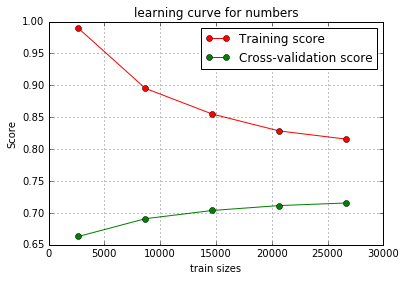

In [10]:
plt.figure()
plt.title("learning curve for numbers")
plt.xlabel("train sizes")
plt.ylabel("Score")
plt.grid()
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc='best')

С ростом выборки качество на тесте растет. Так что предполагаем, что все-таки нужны все объекты.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
from sklearn import grid_search

/home/yury/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:
clf = RandomForestClassifier(n_estimators=200, random_state=2)
params = {
    "class_weight": [{1: 2}, {1: 5}, {1: 10}, {1: 0.5}]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = metrics.scorer.roc_auc_scorer, cv = cv_strategy, n_jobs=4)

In [13]:
%%time
grid_cv.fit(numbers, y)

CPU times: user 19.4 s, sys: 136 ms, total: 19.6 s
Wall time: 1min 17s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[-1 -1 ..., -1 -1], n_folds=3, shuffle=False, random_state=2),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'class_weight': [{1: 2}, {1: 5}, {1: 10}, {1: 0.5}]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(roc_auc_score, needs_threshold=True), verbose=0)

In [14]:
print grid_cv.best_score_
print grid_cv.best_params_

0.666972752908
{'class_weight': {1: 10}}


In [15]:
params = {
    "class_weight": [{1: 8}, {1: 10}, {1: 15}, {1: 20}, {1: 50}]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = metrics.scorer.roc_auc_scorer, cv = cv_strategy, n_jobs=4)

In [16]:
%%time
grid_cv.fit(numbers, y)

CPU times: user 22.6 s, sys: 148 ms, total: 22.7 s
Wall time: 1min 35s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[-1 -1 ..., -1 -1], n_folds=3, shuffle=False, random_state=2),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'class_weight': [{1: 8}, {1: 10}, {1: 15}, {1: 20}, {1: 50}]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(roc_auc_score, needs_threshold=True), verbose=0)

In [17]:
print grid_cv.best_score_
print grid_cv.best_params_

0.672554789501
{'class_weight': {1: 50}}


In [18]:
params = {
    "class_weight": [{1: 40}, {1: 50}, {1: 70}, {1: 100}, {1:200}]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = metrics.scorer.roc_auc_scorer, cv = cv_strategy, n_jobs=4)

In [19]:
%%time
grid_cv.fit(numbers, y)

CPU times: user 21.5 s, sys: 136 ms, total: 21.6 s
Wall time: 1min 55s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[-1 -1 ..., -1 -1], n_folds=3, shuffle=False, random_state=2),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'class_weight': [{1: 40}, {1: 50}, {1: 70}, {1: 100}, {1: 200}]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(roc_auc_score, needs_threshold=True), verbose=0)

In [20]:
print grid_cv.best_score_
print grid_cv.best_params_

0.672904964237
{'class_weight': {1: 40}}


In [21]:
params = {
    "class_weight": [{1: 40}, {1: 30}, {1: 20}, 'balanced']
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = metrics.scorer.roc_auc_scorer, cv = cv_strategy, n_jobs=4)

In [22]:
%%time
grid_cv.fit(numbers, y)

CPU times: user 21.3 s, sys: 184 ms, total: 21.4 s
Wall time: 1min 15s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[-1 -1 ..., -1 -1], n_folds=3, shuffle=False, random_state=2),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'class_weight': [{1: 40}, {1: 30}, {1: 20}, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(roc_auc_score, needs_threshold=True), verbose=0)

In [23]:
print grid_cv.best_score_
print grid_cv.best_params_

0.672904964237
{'class_weight': {1: 40}}


Видим, что результаты немного меняются, наилучший вес в районе 40.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [24]:
!pip install ./imbalanced-learn-0.1.9/

Processing ./imbalanced-learn-0.1.9
  Running setup.py bdist_wheel for imbalanced-learn ... - done
  Stored in directory: /home/yury/.cache/pip/wheels/52/5c/2d/3994e4c7e0121638d04915a299e45c8debefee6ef89876e881
Successfully built imbalanced-learn
You are using pip version 8.0.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
from imblearn import under_sampling as us

In [26]:
sampler = us.RandomUnderSampler(random_state=10)
X_res, y_res = sampler.fit_sample(numbers, y)
(len(X_res), len(y_res))

(5952, 5952)

In [27]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X_res, y_res, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.7075618726695283

In [28]:
sampler = us.NearMiss(random_state=10)
X_res1, y_res1 = sampler.fit_sample(numbers, y)
(len(X_res1), len(y_res1))

/home/yury/anaconda2/lib/python2.7/site-packages/imblearn/under_sampling/nearmiss.py:161: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger than'


(5952, 5952)

In [29]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X_res1, y_res1, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.94468466143123475

Очень хорошее качество на кроссвалидации, попробуем проверить на тестовых данных через каггл.

In [30]:
test = pd.read_csv("orange_small_churn_test_data.csv", index_col='ID')
test_numbers = test.ix[:, 0:190]
test_numbers.fillna(0, inplace=True)
test_numbers.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1225,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,896,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,791,7,0,0,0,...,14,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,2296,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,28,0,...,0,0,0,0,0,0,2,0,0,0


In [31]:
clf.fit(X_res1, y_res1)
result = clf.predict_proba(test_numbers)
result[:5]

array([[ 0.0033756 ,  0.9966244 ],
       [ 0.00497785,  0.99502215],
       [ 0.00485268,  0.99514732],
       [ 0.00153335,  0.99846665],
       [ 0.01353146,  0.98646854]])

In [32]:
def write_result(result, filename):
    churn_probs = [x[1] for x in result]
    ids = range(len(churn_probs))
    df = pd.DataFrame(index=ids, data=churn_probs, columns=['result'])
    df.to_csv(filename)

In [33]:
write_result(result, "result5.csv")

Очки: 5.2 - довольно низкое качество, видимо это переобучение. Попробуем еще способ.

In [34]:
sampler = us.ClusterCentroids(random_state=10)
X_res2, y_res2= sampler.fit_sample(numbers, y)
(len(X_res2), len(y_res2))

(5952, 5952)

In [35]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X_res2, y_res2, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98849363456035377

качество еще выше, скорее всего переобучение еще сильнее.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [36]:
#вариант с заполнением нулями - numbers, запишем кросс-валидацию
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, numbers, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.71555704093979922

In [37]:
#проставляем предыдущее значение c помощью следующего
miss_fill1 = pd.read_csv("orange_small_churn_train_data.csv", index_col='ID').ix[:, 0:190]
miss_fill1.fillna(method='bfill', inplace=True)
miss_fill1.dropna(axis=1, inplace=True)

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, miss_fill1, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.65673382331382513

In [38]:
#заполним пропуски средним значением по столбцу
miss_fill2 = pd.read_csv("orange_small_churn_train_data.csv", index_col='ID').ix[:, 0:190]
for i in range(190):
    col = miss_fill2.ix[:, i]
    mean = col.mean()
    col.fillna(mean, inplace=True)

miss_fill2.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
ID,,,,,,,,,,,,,,,,,,,,,
0,11.003509,0.00497,429.328358,0.148235,249055.515021,3052,6.792126,NaN,47.487719,381346.56309,...,0,1401428.414118,80676.574553,7.419483,NaN,3.515789,16.05614,165.10831,270.585523,22637.159019
1,11.003509,0.00497,429.328358,0.148235,249055.515021,1813,7.000000,NaN,47.487719,381346.56309,...,0,1401428.414118,80676.574553,7.419483,NaN,3.515789,16.05614,165.10831,276.000000,22637.159019
2,11.003509,0.00497,429.328358,0.148235,249055.515021,1953,7.000000,NaN,47.487719,381346.56309,...,0,1401428.414118,80676.574553,7.419483,NaN,3.515789,16.05614,165.10831,270.585523,22637.159019
3,11.003509,0.00497,429.328358,0.148235,249055.515021,1533,7.000000,NaN,47.487719,381346.56309,...,0,1401428.414118,80676.574553,7.419483,NaN,3.515789,16.05614,165.10831,270.585523,22637.159019
4,11.003509,0.00497,429.328358,0.148235,249055.515021,686,7.000000,NaN,47.487719,381346.56309,...,0,1401428.414118,80676.574553,7.419483,NaN,3.515789,16.05614,165.10831,270.585523,22637.159019


In [39]:
miss_fill2.dropna(axis=1, inplace=True)

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, miss_fill2, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.71726900646332148

видим, что заполнение средним дает наиболее хороший результат, но не сильно выше, чем простое заполнение нулями

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [8]:
cat_as_nums = pd.read_csv("categories_only_as_numbers.csv", index_col="ID")

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, cat_as_nums, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.9814355461241201

In [41]:
bin_with_nums = pd.read_csv("categories_binarized_and_as_numbers.csv", index_col="ID")

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, bin_with_nums, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98151370242554759

посмотрим тоже самое, только вместе с остальными признаками

In [9]:
nums = pd.concat([numbers, cat_as_nums], axis=1)

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, nums, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98399583683813507

In [43]:
nums_bins = pd.concat([numbers, bin_with_nums], axis=1)

clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, nums_bins, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98396621238085624

обработанные категориальные признаки увеличивают качество модели, причем совсем чуть-чуть более хорошее качество дает вариант с заменой всех категориальных признаков на числа.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [44]:
from sklearn import feature_selection as fs
from sklearn.svm import LinearSVC

In [45]:
# отберем признаки по линейной модели с помощью l1 регуляризатора
sfm = fs.SelectFromModel(LinearSVC(penalty="l1", dual=False))
X = sfm.fit_transform(nums, y)
X.shape

(40000, 139)

In [46]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98344091858299876

результаты уже были невероятно хорошими, скорее всего переобучены, после отбора качество немного ухудшилось, но это не значит, что в действительности стало хуже.

In [47]:
# рекурсивное удаление признаков с шагами кросс-валидации
estimator = LinearSVC(penalty="l1", dual=False)
selector = fs.RFECV(estimator, step=1, cv=5)
selector = selector.fit(nums, y)
X2 = selector.transform(nums)
X2.shape

(40000, 1)

Очень много призников отсеялось, результаты стали хуже

In [48]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X2, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.88075183460223405

In [49]:
# выберем лучшие признаки на основе статистики хи-квадрат
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [50]:
X_new1 = SelectKBest(f_classif, k=150).fit_transform(nums, y)
X_new2 = SelectKBest(f_classif, k=100).fit_transform(nums, y)
X_new2.shape

/home/yury/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  7  14  19  30  31  38  41  47  51  54  78 140 166 168 174 184] are constant.
  UserWarning)


(40000, 100)

In [51]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X_new1, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.98406104322031085

In [52]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=2)
forest_scoring = cross_validation.cross_val_score(clf, X_new2, y, scoring = metrics.scorer.roc_auc_scorer)
forest_scoring.mean()

0.97902399943919782

Вывод: на данном классификаторе отбор признаков почти не изменил модель, слишком сильный отбор сделал немного хуже. На RandomForest ситуация была другая: там обор признаков несколько улучшил модель, поэтому нельзя однозначно сказать о влиянии отбора признаков по данным тестам. Из опробованных вариантов селектор на основе линейной модели с l1 регуляризатором сразу дает оптимальный результат. Похожий результат можно достич, если поиграть с количеством признаков в селекторе k лучших признаков. В целом, отбор признаков положительно влияет на модель.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [59]:
clf = GradientBoostingClassifier(n_estimators=500, random_state=2)
clf.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'presort': 'auto',
 'random_state': 2,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [73]:
sampler = us.ClusterCentroids(random_state=10)
X_und, y_und= sampler.fit_sample(X, y)
(len(X_und), len(y_und))

(5952, 5952)

In [12]:
sampler = us.ClusterCentroids(random_state=10)
nums_und, y_und2 = sampler.fit_sample(nums, y)
(len(nums_und), len(y_und2))

(5952, 5952)

Поскольку roc_auc после обработки даже на стандартных параметрах алгоритма показывает близкое к максимальному качество, для подбора параметров будем смотреть только на 'average_precision' метрику

In [75]:
params = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.05, 0.01, 0.2]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = 'average_precision', n_jobs=4)

In [76]:
%%time
grid_cv.fit(X_und, y_und)

CPU times: user 11.3 s, sys: 104 ms, total: 11.4 s
Wall time: 1min 42s


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.01, 0.05, 0.01, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [77]:
print grid_cv.best_score_
print grid_cv.best_params_

0.998686763891
{'loss': 'deviance', 'learning_rate': 0.2}


In [78]:
%%time
grid_cv.fit(nums_und, y_und2)

CPU times: user 20.5 s, sys: 124 ms, total: 20.6 s
Wall time: 2min 54s


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.01, 0.05, 0.01, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [79]:
print grid_cv.best_score_
print grid_cv.best_params_

0.997876025591
{'loss': 'exponential', 'learning_rate': 0.2}


In [91]:
params = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.2, 0.3]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = 'roc_auc', n_jobs=4)

In [92]:
%%time
grid_cv.fit(nums_und, y_und2)

CPU times: user 21 s, sys: 140 ms, total: 21.1 s
Wall time: 2min 23s


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [93]:
print grid_cv.best_score_
print grid_cv.best_params_

0.998590877558
{'loss': 'deviance', 'learning_rate': 0.2}


In [86]:
params = {
    'loss': ['exponential'],
    'learning_rate': [0.2],
    'max_depth': [2, 3, 5, 8],
    'max_features': [0.1, 0.3, 0.6, 0.8]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = 'average_precision', n_jobs=4)

In [89]:
%%time
grid_cv.fit(nums_und, y_und2)

CPU times: user 8.92 s, sys: 124 ms, total: 9.05 s
Wall time: 2min 17s


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [0.1, 0.3, 0.6, 0.8], 'loss': ['exponential'], 'learning_rate': [0.2], 'max_depth': [2, 3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [90]:
print grid_cv.best_score_
print grid_cv.best_params_

0.998610247611
{'max_features': 0.3, 'loss': 'exponential', 'learning_rate': 0.2, 'max_depth': 5}


In [94]:
params = {
    'loss': ['exponential'],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'max_features': [0.3, 0.5],
    'n_estimators': [300, 500, 1000]
}
grid_cv = grid_search.GridSearchCV(clf, params, scoring = 'average_precision', n_jobs=4)

In [95]:
%%time
grid_cv.fit(nums_und, y_und2)

CPU times: user 9.1 s, sys: 152 ms, total: 9.25 s
Wall time: 4min 15s


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [0.3, 0.5], 'loss': ['exponential'], 'learning_rate': [0.1, 0.2], 'n_estimators': [300, 500, 1000], 'max_depth': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [96]:
print grid_cv.best_score_
print grid_cv.best_params_

0.998610247611
{'max_features': 0.3, 'loss': 'exponential', 'learning_rate': 0.2, 'n_estimators': 300, 'max_depth': 5}


Подбор параметров немного улучшил качество модели, главное, чтобы она не стала более переобучена.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Посмотрим первые 20 признаков через feature\_importances_

In [13]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, max_depth=5, loss='exponential', max_features=0.3, random_state=2)
clf.fit(nums_und, y_und2)
clf.feature_importances_[:10]

array([  3.61688496e-04,   0.00000000e+00,   7.60758071e-04,
         8.99901406e-05,   1.37398727e-03,   7.95494837e-03,
         1.15560490e-03,   0.00000000e+00,   1.13804703e-05,
         3.33716559e-03])

In [101]:
feat_names = zip(clf.feature_importances_, nums.columns)
feat_names[:10]

[(0.00036168849628620043, 'Var1'),
 (0.0, 'Var2'),
 (0.0007607580706560775, 'Var3'),
 (8.9990140556278406e-05, 'Var4'),
 (0.0013739872694488997, 'Var5'),
 (0.0079549483699781938, 'Var6'),
 (0.0011556049040075777, 'Var7'),
 (0.0, 'Var8'),
 (1.1380470283345421e-05, 'Var9'),
 (0.0033371655893571902, 'Var10')]

In [106]:
indexes = sorted(feat_names, reverse=True)
indexes[:20]

[(0.050883874523689678, 'Var214'),
 (0.039591494838676973, 'Var76'),
 (0.036588990243558148, 'Var217'),
 (0.036383969389647421, 'Var81'),
 (0.033372534704412926, 'Var113'),
 (0.031536939409216994, 'Var200'),
 (0.03079549069128764, 'Var204'),
 (0.029670842931906728, 'Var153'),
 (0.027356300518974419, 'Var202'),
 (0.026309610499057428, 'Var192'),
 (0.023688656703545571, 'Var199'),
 (0.022980377140476366, 'Var216'),
 (0.021598303524235803, 'Var57'),
 (0.021285516321626716, 'Var189'),
 (0.017938243068868695, 'Var149'),
 (0.014949673163555671, 'Var133'),
 (0.014119807336105562, 'Var197'),
 (0.01400067820750603, 'Var163'),
 (0.013408225796611314, 'Var28'),
 (0.013181533439226616, 'Var126')]

20 признаков выше внесли больший вклад в модель, соотстветственно остальные - меньший

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [14]:
preds = clf.predict_proba(nums)

In [15]:
y_norm = [0 if x==-1 else x for x in y]
y_norm[:10]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [17]:
diffs = [abs(y_norm[i] - preds[i][1]) for i in range(len(preds))]
diffs[:10]

[9.7181186308611554e-16,
 3.4435149843201306e-15,
 0.99979246320265658,
 8.0388140588638635e-11,
 1.6825122158435758e-11,
 1.8274071357479562e-11,
 0.93153499906845472,
 0.99999997225985682,
 0.99999999995100208,
 1.904910343876489e-06]

In [18]:
obj_errs = zip (diffs, range(len(preds)))
sort_errs = sorted(obj_errs, reverse=True)
sort_errs[:10]

[(0.99999999999941758, 36375),
 (0.99999999999832601, 15654),
 (0.99999999999647193, 4121),
 (0.9999999999961886, 11002),
 (0.99999999999465339, 7535),
 (0.99999999999423594, 11213),
 (0.99999999999332911, 30601),
 (0.99999999999269917, 32159),
 (0.99999999999247824, 6015),
 (0.9999999999922986, 17544)]

In [21]:
[nums.ix[x[1]][:10] for x in sort_errs[:10]]

[Var1        0
 Var2        0
 Var3        0
 Var4        0
 Var5        0
 Var6     1169
 Var7        0
 Var8        0
 Var9        0
 Var10       0
 Name: 36375, dtype: float64, Var1        0
 Var2        0
 Var3        0
 Var4        0
 Var5        0
 Var6     1043
 Var7        7
 Var8        0
 Var9        0
 Var10       0
 Name: 15654, dtype: float64, Var1       0
 Var2       0
 Var3       0
 Var4       0
 Var5       0
 Var6     490
 Var7       0
 Var8       0
 Var9       0
 Var10      0
 Name: 4121, dtype: float64, Var1       0
 Var2       0
 Var3       0
 Var4       0
 Var5       0
 Var6     574
 Var7       0
 Var8       0
 Var9       0
 Var10      0
 Name: 11002, dtype: float64, Var1        0
 Var2        0
 Var3        0
 Var4        0
 Var5        0
 Var6     3248
 Var7        7
 Var8        0
 Var9        0
 Var10       0
 Name: 7535, dtype: float64, Var1       0
 Var2       0
 Var3       0
 Var4       0
 Var5       0
 Var6     798
 Var7      14
 Var8       0
 Var9       0
 

Можно предположить, что почти все такие признаки имеет очень много нулей и пропусков, а некоторые из них довольно большие, совершенно скачущие значения, не коррелирующие с целевой переменной, поэтому алгоритм классификации ошибается на них.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Собственно, модель и ее качество проиллюстрированы в пункте 7. Здесь опишем шаги:

1. Отфильтровать колонки, содержащие только NaN значения.
2. В числовых признаках заполнить пропуски средним по столбцу.
3. Категориальные признаки перекодировать в числа.
4. Сделать undersampling на кластерных центроидах.
5. Отбор призников не взяли в модель, но нужно проверять на тестовых данных на каггл, так как они все же могут уменьшить переобучение.
6. Обучить градиентный бустинг со следующими параметрами: n_estimators=300, learning_rate=0.2, max_depth=5, loss='exponential', max_features=0.3

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Основная проблема в том, что оценка качества по кросс-валидации не дает желаемого результата. То есть улучшая модель здесь, применяя различные обработки данных, на тестовых данных на каггл классе ситуация обратная, пока что наилучший результат дала практически необработанная модель, что очень странно. 
Поэтому необходимо понять, как метрику качества привести в соответствие с оценкой качества на тестовых данных, чтобы можно было быть уверенным, что при улучшении модели предсказание действительно будет лучше.